Dataset Head:
   time  nasal_airflow  apnea_event  hypopnea_event     event  recording
0  0.00       0.010615            0               0    normal          0
1  0.01      -0.022384            0               1  hypopnea          0
2  0.02      -0.055600            0               0    normal          0
3  0.03       0.069761            0               0    normal          0
4  0.04      -0.112263            0               0    normal          0

Missing Values:
time              0
nasal_airflow     0
apnea_event       0
hypopnea_event    0
event             0
recording         0
dtype: int64

Event Distribution:
event
normal      512927
hypopnea     56988
apnea        30085
Name: count, dtype: int64


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,553 (41.22 KB)

 Trainable params: 10,553 (41.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
14998/14998 ━━━━━━━━━━━━━━━━━━━━ 1064s 71ms/step - accuracy: 0.8531 - loss: 0.5145 - val_accuracy: 0.8549 - val_loss: 0.5082
Epoch 2/10
14998/14998 ━━━━━━━━━━━━━━━━━━━━ 18372s 1s/step - accuracy: 0.8549 - loss: 0.5082 - val_accuracy: 0.8549 - val_loss: 0.5076
Epoch 3/10
14998/14998 ━━━━━━━━━━━━━━━━━━━━ 1056s 70ms/step - accuracy: 0.8545 - loss: 0.5092 - val_accuracy: 0.8549 - val_loss: 0.5083
Epoch 4/10
14998/14998 ━━━━━━━━━━━━━━━━━━━━ 1013s 68ms/step - accuracy: 0.8560 - loss: 0.5053 - val_accuracy: 0.8549 - val_loss: 0.5076
Epoch 5/10
14998/14998 ━━━━━━━━━━━━━━━━━━━━ 1017s 68ms/step - accuracy: 0.8555 - loss: 0.5066 - val_accuracy: 0.8549 - val_loss: 0.5076
Epoch 6/10
14998/14998 ━━━━━━━━━━━━━━━━━━━━ 4963s 331ms/step - accuracy: 0.8550 - loss: 0.5079 - val_accuracy: 0.8549 - val_loss: 0.5075
Epoch 7/10
14998/14998 ━━━━━━━━━━━━━━━━━━━━ 935s 62ms/step - accuracy: 0.8550 - loss: 0.5077 - val_accuracy: 0.8549 - val_loss: 0.5076
Epoch 8/10
14998/14998 ━━━━━━━━━━━━━━━━━━━━ 810s 

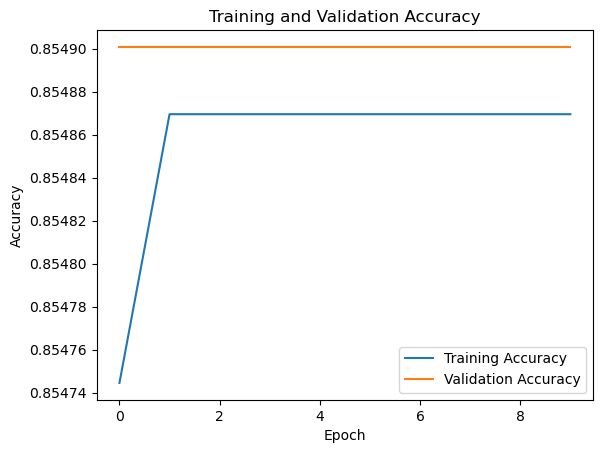


Model saved as 'apnea_detection_lstm_model.h5'.


"\nfrom flask import Flask, request, jsonify\nimport numpy as np\nfrom tensorflow.keras.models import load_model\n\napp = Flask(__name__)\n\n# Load the model\nmodel = load_model('apnea_detection_lstm_model.h5')\n\n@app.route('/predict', methods=['POST'])\ndef predict():\n    data = request.json['data']  # Input sequence\n    data = np.array(data).reshape(1, timesteps, 1)  # Reshape for LSTM input\n    prediction = model.predict(data)\n    predicted_class = np.argmax(prediction, axis=1)\n    return jsonify({'prediction': int(predicted_class[0])})\n\nif __name__ == '__main__':\n    app.run(debug=True)\n"

In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import matplotlib.pyplot as plt

# Step 2: Load the Dataset
data = pd.read_csv('enhanced_respiration_data.csv')

# Inspecting the dataset
print("Dataset Head:")
print(data.head())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nEvent Distribution:")
print(data['event'].value_counts())

# Step 3: Preprocess the Data
# Handleing missing values (if any)
data = data.dropna()

# Normalize/Standardize the nasal airflow signal
scaler = StandardScaler() 
data['nasal_airflow'] = scaler.fit_transform(data[['nasal_airflow']])

# Encode labels (convert categorical to numerical)
label_encoder = LabelEncoder()
data['event'] = label_encoder.fit_transform(data['event'])

# Step 4: Prepare Data for Sequence Model (LSTM)
# Convert data into sequences
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data['nasal_airflow'].iloc[i:i+timesteps])  # Input sequence
        y.append(data['event'].iloc[i+timesteps])  # Corresponding label
    return np.array(X), np.array(y)

timesteps = 100  # Number of timesteps in each sequence
X, y = create_sequences(data, timesteps)

# Reshape X to be 3D: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Convert y to categorical (one-hot encoding)
y = to_categorical(y)

# Step 5: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Build the LSTM Model
# Define the LSTM model
num_classes = 3
model = Sequential()
model.add(Input(shape=(100, 1)))  # Use Input layer as the first layer
model.add(LSTM(50))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Step 7: Train the LSTM Model
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the Model
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Step 9: Save the Model
# Save the trained LSTM model to a file
model.save('apnea.keras') # This uses the new Keras format

print("\nModel saved as 'apnea_detection_lstm_model.h5'.")

# Step 10: Deploy the Model (Optional)
